In [1]:
import time
start_time = time.time()

# Preparation - Load the packages and the data

Import the packages and load the data

In [2]:
# Import needed packages
import os
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import KBinsDiscretizer
import seaborn as sns; sns.set()
import glob
from sklearn.linear_model import LinearRegression
from statsmodels.formula.api import ols
import re
import nltk
from langdetect import detect
from sklearn import feature_extraction, model_selection, naive_bayes, pipeline, manifold, preprocessing
from lime import lime_text
import gensim
import gensim.downloader as gensim_api
from tensorflow.keras import models, layers, preprocessing as kprocessing
from tensorflow.keras import backend as K
import transformers
plt.style.use('seaborn-whitegrid')
sns.set_style("whitegrid")
from bs4 import BeautifulSoup
from tqdm import tqdm
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.snowball import EnglishStemmer
import spacy
from spacy import displacy
from wordcloud import WordCloud
from sklearn.preprocessing import KBinsDiscretizer
from nbpep8.nbpep8 import pep8
from sklearn.metrics.pairwise import cosine_similarity


In [3]:
#Set the working directory
os.chdir('C:\\Users\\piotr\\OneDrive - Erasmus University Rotterdam\\Thesis\\')

In [4]:
#Load the merged_df from the directory 'C:\\Users\\piotr\\OneDrive - Erasmus University Rotterdam\\Thesis\\Master Thesis Data\\':
merged_df = pd.read_csv('Master Thesis Data\\df_clean_transformed.csv')

ADD the FIX now!

In [5]:
df_MAT = pd.read_csv('Master Thesis Data\\FIX\\merged_df_after_notebook5_FIX.csv')
#Drop answer body from df_MAT
df_MAT = df_MAT.drop(['Answer_Body'], axis=1)
#Concat the dfs
df = pd.concat([merged_df, df_MAT], ignore_index=True)
# show forum counts in df
print(df['Forum'].value_counts())

Stack Overflow                  2451718
Mathematics                      165729
Stack Overflow in Russian         73932
Stack Overflow in Spanish         41099
Ask Ubuntu                        37819
Super User                        36193
MathOverflow                      34322
Physics                           32556
Statistical Analysis              29399
Unix and Linux                    27819
TeX - LaTeX                       27798
Electrical Engineering            26176
Blender                           23378
GIS                               19150
Server Fault                      19065
Salesforce                        15999
Ethereum                          15056
English Language Learners         14325
Home Improvement                  12089
Ask Different                     11956
Mathematica                       10485
Database Administrators           10019
English                            7245
Magento                            7200
WordPress                          7126


In [6]:
df.shape

(3206459, 30)

In [6]:
#Drop Week_of_Year = 17 and 26
df = df[df['Week_of_Year'] != 17]
df = df[df['Week_of_Year'] != 26]

Uncomment for the final run

In [8]:
df_backup = df.copy()

Temporary - create a sample!

In [9]:
# df.shape

In [10]:
# #df is a sample of 100000 rows from the merged_df
# df = df.copy().sample(300000, random_state=42)

In [11]:
df.head(0)

,Post_Creation_Date,Post_View_Count,Post_Title,Post_Score,Post_Answer_Count,Response_Scores,Post_Author,Answer_Author,Forum,Week_of_Year,...,Post_Body,Post_Body_EN,ari,fre,fk_grade,gunning_fog,smog_index,coleman_liau_index,lix,rix


In [7]:
#Rename the columns
df = df.rename(columns={'Post_Body': 'Body', 'Post_Body_clean': 'Body_clean', 'tag_combined' : "tag23FE"})

# 4. Content Novelty Analysis

In [8]:
pd.set_option('display.max_columns', None)

### 5.1 Load the files from the first notebook

Code for loading the data base here

File cleaned and prepared in the first notebook is merged_df that contains all observations (except NA's). Also the unknown User ID's = (0) are left as we not get down on user level. Text is cleaned and lemmatized.

In [14]:
df.shape

(3107968, 30)

In [15]:
df.head(5)

,Post_Creation_Date,Post_View_Count,Post_Title,Post_Score,Post_Answer_Count,Response_Scores,Post_Author,Answer_Author,Forum,Week_of_Year,tag_1,tag_2,tag_3,Body_clean,tag23FE,Weekly_Post_Count,D,T,Title_Length,Body_Length,Body,Post_Body_EN,ari,fre,fk_grade,gunning_fog,smog_index,coleman_liau_index,lix,rix
14514,2021-07-05 00:00:24,126,Scraping nested html with Selenium,1,1,0,16379541,7326738,Stack Overflow,27,python,selenium,NaN,im looking help scraping selenium python need ...,pythonselenium,72503,0,0,34,3001,<p>I'm looking for some help with scraping wit...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14515,2021-07-05 00:00:29,138,You should use prepared statements for accurat...,0,1,1,16379618,4269535,Stack Overflow,27,cassandra,NaN,NaN,get error message query,cassandra,72503,0,0,60,862,<p>Why I get this error message ?</p>\n<pre><c...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14516,2021-07-05 00:00:38,66,I try to Run this Mobilenet script,-1,1,0,7118337,0,Stack Overflow,27,python,tensorflow,keras,try run python code httpsgithubcomtensorflowte...,pythontensorflow,72503,0,0,34,352,"<p>I am try to run this python code\n<a href=""...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14517,2021-07-05 00:01:07,58,Strange referenceError only occurs on first lo...,-3,2,2,8900748,0,Stack Overflow,27,javascript,node.js,fetch,im getting referenceerror ive unable figure ti...,javascriptnode.js,72503,0,0,57,2894,<p>I'm getting a referenceError which I've bee...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14518,2021-07-05 00:01:49,1480,Meaning of tilde and dot notation in dplyr,3,2,12,16379550,0,Stack Overflow,27,r,dplyr,across,summary reading article subject dplyrs across ...,dplyrr,72503,0,0,42,1386,<p><strong>Summary</strong>\nI was reading an ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 5.2 Explore the data a bit

In [16]:
#Show the counts of df['tag23FE'] - top 30
df['tag23FE'].value_counts().head(30)


pandaspython         52646
javascriptreactjs    46316
htmljavascript       45348
pythonpython-3.x     33584
csshtml              30861
python               27236
javascriptnode.js    25983
dartflutter          21628
javascript           18123
djangopython         17965
androidjava          16488
excelvba             14488
iosswift             13681
.netc#               13485
javaspring           12890
androidkotlin        12472
laravelphp           11701
sqlsql-server        11195
arraysjavascript     11055
javascriptjquery     10512
r                    10455
javaspring-boot       9492
ggplot2r              9221
numpypython           8588
listpython            8501
mysqlsql              8492
reactjstypescript     8407
reactjs               7896
c++                   7865
pythontensorflow      7498
Name: tag23FE, dtype: int64

In [17]:
#Show the counts of df['tag23FE'] - top 30
df['tag23FE'].value_counts().head(30)

pandaspython         52646
javascriptreactjs    46316
htmljavascript       45348
pythonpython-3.x     33584
csshtml              30861
python               27236
javascriptnode.js    25983
dartflutter          21628
javascript           18123
djangopython         17965
androidjava          16488
excelvba             14488
iosswift             13681
.netc#               13485
javaspring           12890
androidkotlin        12472
laravelphp           11701
sqlsql-server        11195
arraysjavascript     11055
javascriptjquery     10512
r                    10455
javaspring-boot       9492
ggplot2r              9221
numpypython           8588
listpython            8501
mysqlsql              8492
reactjstypescript     8407
reactjs               7896
c++                   7865
pythontensorflow      7498
Name: tag23FE, dtype: int64

In [18]:
#Count the NaN values in each column
df.isnull().sum()

Post_Creation_Date          0
Post_View_Count             0
Post_Title                  0
Post_Score                  0
Post_Answer_Count           0
Response_Scores             0
Post_Author                 0
Answer_Author               0
Forum                       0
Week_of_Year                0
tag_1                      67
tag_2                  399206
tag_3                 1188922
Body_clean             133476
tag23FE                    10
Weekly_Post_Count           0
D                           0
T                           0
Title_Length                0
Body_Length                 0
Body                        0
Post_Body_EN          2951007
ari                   2947783
fre                   2947783
fk_grade              2947783
gunning_fog           2947783
smog_index            2947783
coleman_liau_index    2947783
lix                   2956281
rix                   2956281
dtype: int64

In [19]:
df.shape

(3107968, 30)

### 5.3 Filter out the tag combination that have less than 50 (20) data points in each of the four periods

In [20]:
df

,Post_Creation_Date,Post_View_Count,Post_Title,Post_Score,Post_Answer_Count,Response_Scores,Post_Author,Answer_Author,Forum,Week_of_Year,tag_1,tag_2,tag_3,Body_clean,tag23FE,Weekly_Post_Count,D,T,Title_Length,Body_Length,Body,Post_Body_EN,ari,fre,fk_grade,gunning_fog,smog_index,coleman_liau_index,lix,rix
14514,2021-07-05 00:00:24,126,Scraping nested html with Selenium,1,1,0,16379541,7326738,Stack Overflow,27,python,selenium,NaN,im looking help scraping selenium python need ...,pythonselenium,72503,0,0,34,3001,<p>I'm looking for some help with scraping wit...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14515,2021-07-05 00:00:29,138,You should use prepared statements for accurat...,0,1,1,16379618,4269535,Stack Overflow,27,cassandra,NaN,NaN,get error message query,cassandra,72503,0,0,60,862,<p>Why I get this error message ?</p>\n<pre><c...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14516,2021-07-05 00:00:38,66,I try to Run this Mobilenet script,-1,1,0,7118337,0,Stack Overflow,27,python,tensorflow,keras,try run python code httpsgithubcomtensorflowte...,pythontensorflow,72503,0,0,34,352,"<p>I am try to run this python code\n<a href=""...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14517,2021-07-05 00:01:07,58,Strange referenceError only occurs on first lo...,-3,2,2,8900748,0,Stack Overflow,27,javascript,node.js,fetch,im getting referenceerror ive unable figure ti...,javascriptnode.js,72503,0,0,57,2894,<p>I'm getting a referenceError which I've bee...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14518,2021-07-05 00:01:49,1480,Meaning of tilde and dot notation in dplyr,3,2,12,16379550,0,Stack Overflow,27,r,dplyr,across,summary reading article subject dplyrs across ...,dplyrr,72503,0,0,42,1386,<p><strong>Summary</strong>\nI was reading an ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3204282,2023-04-23 23:39:14,32,Class of well-founded set being a subclass WF ...,0,1,0,854260,0,Mathematics,16,set-theory,NaN,NaN,im trying show kunen cha iii ex 3 let class fo...,set-theory,3959,1,1,57,438,<p>I'm trying to show (Kunen Cha III Ex 3) let...,I'm trying to show (Kunen Cha III Ex 3) let M ...,7.6,78.89,6.7,8.59,10.5,4.12,36.534591,3.333333
3204283,2023-04-23 23:45:43,112,Prove that $\limsup \ \frac{B\left(t\right)}{\...,5,2,3,751096,0,Mathematics,16,probability,probability-theory,probability-distributions,let bt standard brownian motion need prove und...,probabilityprobability-theory,3959,1,1,65,523,"<p>Let <span class=""math-container"">$B(t)$</sp...",Let $B(t)$ be a Standard Brownian Motion.\nWe ...,15.9,62.98,8.6,8.28,11.9,11.66,40.666667,4.000000
3204284,2023-04-23 23:45:45,35,simple functions are in Lp,1,0,0,627082,0,Mathematics,16,real-analysis,NaN,NaN,let xmmu measure space displaystyle fsum_j1n a...,real-analysis,3959,1,1,26,1085,"<blockquote>\n<p>Let <span class=""math-contain...","\nLet $(X,M,\mu)$ be a measure space. For $\di...",22.6,69.68,6.0,5.73,9.2,17.66,45.636150,4.000000
3204285,2023-04-23 23:50:28,32,Proving possibilities of building bipartite 2 ...,2,1,2,1174063,1174161,Mathematics,16,discrete-mathematics,graph-theory,coloring,want show build twocolorable graph n n vertex ...,discrete-mathematicsgraph-theory,3959,1,1,76,1841,<p>I want to show that I can you can build a t...,I want to show that I can you can build a two-...,10.2,74.73,8.3,10.41,9.7,6.04,37.652121,3.500000


In [9]:
#Print the count of unique values of the ['tag23FE'] column
print('Number of unique values in the column tag23FE:', df['tag23FE'].nunique())

Number of unique values in the column tag23FE: 342991


In [10]:
# #Run only once!
# The number has to be consistent with the further part

# Filter and count based on each condition
cond1_df = df[(df['D'] == 0) & (df['T'] == 0)].groupby('tag23FE').size().reset_index(name='count1')
cond2_df = df[(df['D'] == 0) & (df['T'] == 1)].groupby('tag23FE').size().reset_index(name='count2')
cond3_df = df[(df['D'] == 1) & (df['T'] == 0)].groupby('tag23FE').size().reset_index(name='count3')
cond4_df = df[(df['D'] == 1) & (df['T'] == 1)].groupby('tag23FE').size().reset_index(name='count4')

# Merge the counts for all conditions
merged_counts = cond1_df.merge(cond2_df, on='tag23FE', how='outer').merge(cond3_df, on='tag23FE', how='outer').merge(cond4_df, on='tag23FE', how='outer')

# Fill NaNs with 0
merged_counts = merged_counts.fillna(0)

# Merge original dataframe with the counts
df = df.merge(merged_counts, on='tag23FE', how='left')

# Filter for values with at least 50 observations in each period
df = df[(df['count1'] >= 50) & (df['count2'] >= 50) & (df['count3'] >= 50) & (df['count4'] >= 50)]

# Sort the filtered counts in descending order based on the total count
df['total_count'] = df[['count1', 'count2', 'count3', 'count4']].sum(axis=1)
df = df.sort_values(by='total_count', ascending=False).drop('total_count', axis=1)

# Display the filtered counts
print(df)

          Post_Creation_Date  Post_View_Count  \
1139380  2021-10-15 10:55:48              337   
2434052  2021-08-16 11:58:57               79   
842591   2021-08-02 11:45:46              262   
2708167  2023-03-31 08:19:13               36   
74201    2021-10-31 11:17:43              295   
...                      ...              ...   
1289824  2022-10-31 13:16:02               83   
976272   2021-09-04 11:51:22              250   
1674724  2023-01-31 12:40:17               17   
864688   2021-08-07 11:19:53              421   
1494206  2022-12-14 23:54:02               23   

                                                Post_Title  Post_Score  \
1139380  TypeError: cannot convert the series to <class...           1   
2434052  Уравнивание пользователей в одном датасете по ...           1   
842591           How to count each word in each row python           1   
2708167  Agregar columnas en dataframe con pandas y python           0   
74201                 matplotlib inset wi

In [23]:
df.reset_index(drop=True, inplace=True)
df.head(5)

,Post_Creation_Date,Post_View_Count,Post_Title,Post_Score,Post_Answer_Count,Response_Scores,Post_Author,Answer_Author,Forum,Week_of_Year,tag_1,tag_2,tag_3,Body_clean,tag23FE,Weekly_Post_Count,D,T,Title_Length,Body_Length,Body,Post_Body_EN,ari,fre,fk_grade,gunning_fog,smog_index,coleman_liau_index,lix,rix,count1,count2,count3,count4
0,2021-10-15 10:55:48,337,TypeError: cannot convert the series to <class...,1,1,1,12275675,2901002,Stack Overflow,41,python,pandas,numpy,following code test stock make new lifetime hi...,pandaspython,72187,0,0,65,1290,<p>I have the following code which tests if a ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14306.0,13434.0,15181.0,9725.0
1,2021-08-16 11:58:57,79,Уравнивание пользователей в одном датасете по ...,1,0,0,456968,0,Stack Overflow in Russian,33,python,pandas,NaN,NaN,pandaspython,72557,0,0,82,2269,<p>У меня есть 2 датасета (для примера взял ми...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14306.0,13434.0,15181.0,9725.0
2,2021-08-02 11:45:46,262,How to count each word in each row python,1,1,0,16343159,0,Stack Overflow,31,python,pandas,counter,dataframe want count occurrence word using cou...,pandaspython,73261,0,0,41,1972,<p>I have a dataframe</p>\n<pre><code>0 ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14306.0,13434.0,15181.0,9725.0
3,2023-03-31 08:19:13,36,Agregar columnas en dataframe con pandas y python,0,1,0,325005,0,Stack Overflow in Spanish,13,python,pandas,NaN,NaN,pandaspython,65555,1,1,49,623,"<p>Necesito agregar una columna, la cual me di...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14306.0,13434.0,15181.0,9725.0
4,2021-10-31 11:17:43,295,matplotlib inset with '%H:%M' x-axis,-1,1,0,17132345,0,Stack Overflow,43,python,pandas,datetime,unable successfully plot zoomed inset matplotl...,pandaspython,73215,0,0,36,3064,<p>I am unable to successfully plot a <em>'zoo...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14306.0,13434.0,15181.0,9725.0


In [11]:
#Print the count of unique values of the ['tag23FE'] column
print('Number of unique values in the column tag23FE:', df['tag23FE'].nunique())

Number of unique values in the column tag23FE: 1188


### 5.4 Create a dictionary for with separate data frames, grouped by tag combination

In [12]:
dfs = {k: v for k, v in df.groupby('tag23FE')}

In [13]:
dfs_copy = dfs.copy()

In [14]:
# Show the keys and the counts of dfs (sort descending):
for key, value in dfs.items():
    print(key, len(value))
    

.htaccess 255
.htaccessapache 681
.htaccessphp 389
.net-coreasp.net-core 295
.net-corec# 1947
.netasp.net 488
.netasp.net-core 321
.netazure 282
.netc# 13485
.netvb.net 324
.netvisual-studio 258
abstract-algebra 353
abstract-algebraalgebraic-geometry 321
abstract-algebracommutative-algebra 302
abstract-algebrafield-theory 396
abstract-algebragroup-theory 1740
abstract-algebralinear-algebra 511
abstract-algebrapolynomials 303
abstract-algebraring-theory 1041
ac.commutative-algebraag.algebraic-geometry 308
active-directorypowershell 452
activerecordruby-on-rails 258
acumatica 236
adbandroid 275
ag.algebraic-geometry 394
ag.algebraic-geometrycomplex-geometry 318
ag.algebraic-geometrynt.number-theory 294
aggregation-frameworkmongodb 489
airflow 359
airflowpython 482
ajaxjavascript 846
ajaxjquery 654
ajaxphp 651
algebra-precalculus 664
algebra-precalculuscalculus 351
algebra-precalculusinequality 256
algebraic-geometry 515
algebraic-geometrycommutative-algebra 342
algebraic-topology 256
alg

In [15]:
sorted_dfs = sorted(dfs.items(), key=lambda x: len(x[1]), reverse=True)[:20]

for key, value in sorted_dfs:
    print(key, len(value))


pandaspython 52646
javascriptreactjs 46316
htmljavascript 45348
pythonpython-3.x 33584
csshtml 30861
python 27236
javascriptnode.js 25983
dartflutter 21628
javascript 18123
djangopython 17965
androidjava 16488
excelvba 14488
iosswift 13681
.netc# 13485
javaspring 12890
androidkotlin 12472
laravelphp 11701
sqlsql-server 11195
arraysjavascript 11055
javascriptjquery 10512


In [16]:
for key, df in dfs.items():
    print(f"Shape of DataFrame '{key}': {df.shape}")

Shape of DataFrame '.htaccess': (255, 34)
Shape of DataFrame '.htaccessapache': (681, 34)
Shape of DataFrame '.htaccessphp': (389, 34)
Shape of DataFrame '.net-coreasp.net-core': (295, 34)
Shape of DataFrame '.net-corec#': (1947, 34)
Shape of DataFrame '.netasp.net': (488, 34)
Shape of DataFrame '.netasp.net-core': (321, 34)
Shape of DataFrame '.netazure': (282, 34)
Shape of DataFrame '.netc#': (13485, 34)
Shape of DataFrame '.netvb.net': (324, 34)
Shape of DataFrame '.netvisual-studio': (258, 34)
Shape of DataFrame 'abstract-algebra': (353, 34)
Shape of DataFrame 'abstract-algebraalgebraic-geometry': (321, 34)
Shape of DataFrame 'abstract-algebracommutative-algebra': (302, 34)
Shape of DataFrame 'abstract-algebrafield-theory': (396, 34)
Shape of DataFrame 'abstract-algebragroup-theory': (1740, 34)
Shape of DataFrame 'abstract-algebralinear-algebra': (511, 34)
Shape of DataFrame 'abstract-algebrapolynomials': (303, 34)
Shape of DataFrame 'abstract-algebraring-theory': (1041, 34)
Shape 

# 6. Cosine Similarity Calculation 

## 6.1 TF-IDF

This code calculates the cosine similarity correctly, however there is still potential for optimisation. 50 pairs are drawn for each period. The number of features in the tf-idf vectorizer is set to 1000, and it is set to process mono- and bi-grams (ngram_range) to ensure smooth code running, but those settings can be changed. 

In [30]:
dfs = dfs_copy.copy()

In [31]:
#Import needed packages
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns; sns.set()
import glob
from sklearn.linear_model import LinearRegression
from statsmodels.formula.api import ols
import re
import nltk
## for bag-of-words
from sklearn import feature_extraction, model_selection, naive_bayes, pipeline, manifold, preprocessing
## for explainer
from lime import lime_text
## for word embedding
import gensim
import gensim.downloader as gensim_api
## for deep learning
from tensorflow.keras import models, layers, preprocessing as kprocessing
from tensorflow.keras import backend as K
## for bert language model
import transformers
# for calculating cosine similarity
from sklearn.metrics.pairwise import cosine_similarity
#for plotting
plt.style.use('seaborn-whitegrid')
sns.set_style("whitegrid")
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from gensim import corpora, models
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.utils import simple_preprocess
from itertools import chain

In [32]:


#Previous version - save only the average value of 50 pairs for each question drawn from D0T1

# TfidfVectorizer with 1000 features
tfidf_vectorizer = TfidfVectorizer(max_features=1000, ngram_range=(1, 2))

def calculate_cosine_similarity_matrices(dfs):
    cos_similarity_dict = {}
    
    for key, df in dfs.items():
        tfidf_corpus = df["Body_clean"].fillna(" ")
        tfidf_X_vec = tfidf_vectorizer.fit_transform(tfidf_corpus)
        cos_similarity_dict[key] = tfidf_X_vec.toarray() 

    return cos_similarity_dict

def calculate_cosine_similarity_for_periods(dfs, cos_similarity_dict, n_samples=50):
    for key, df in dfs.items():
        avg_cos_sim_D0 = []
        avg_cos_sim_D1 = []

        df_D0T0 = df[(df['D'] == 0) & (df['T'] == 0)].reset_index(drop=True)
        df_D0T1 = df[(df['D'] == 0) & (df['T'] == 1)].sample(n_samples, random_state=42).reset_index(drop=True)
        df_D1T0 = df[(df['D'] == 1) & (df['T'] == 0)].reset_index(drop=True)
        df_D1T1 = df[(df['D'] == 1) & (df['T'] == 1)].sample(n_samples, random_state=42).reset_index(drop=True)

        # Calculate the average cosine similarity for D=0
        for _, row_D0T1 in df_D0T1.iterrows():
            cos_sim_values = []
            for _, row_D0T0 in df_D0T0.sample(n=n_samples, random_state=42).iterrows():
                cos_sim = cosine_similarity(cos_similarity_dict[key][row_D0T1.name].reshape(1, -1), cos_similarity_dict[key][row_D0T0.name].reshape(1, -1))[0][0]
                cos_sim_values.append(cos_sim)
            avg_cos_sim_D0.append(np.mean(cos_sim_values))

        # Calculate the average cosine similarity for D=1
        for _, row_D1T1 in df_D1T1.iterrows():
            cos_sim_values = []
            for _, row_D1T0 in df_D1T0.sample(n=n_samples, random_state=42).iterrows():
                cos_sim = cosine_similarity(cos_similarity_dict[key][row_D1T1.name].reshape(1, -1), cos_similarity_dict[key][row_D1T0.name].reshape(1, -1))[0][0]
                cos_sim_values.append(cos_sim)
            avg_cos_sim_D1.append(np.mean(cos_sim_values))

        df_D0T1['cos_sim_D0'] = avg_cos_sim_D0
        df_D1T1['cos_sim_D1'] = avg_cos_sim_D1

        # Concatenate the dataframes
        dfs[key] = pd.concat([df_D0T0, df_D0T1, df_D1T0, df_D1T1], ignore_index=True)

    return dfs

# Calculate the cosine similarity matrices for the original dataframes
cos_similarity_dict = calculate_cosine_similarity_matrices(dfs)

# Finally, calculate the average cosine similarity for the periods D=0 and D=1
modified_dfs = calculate_cosine_similarity_for_periods(dfs, cos_similarity_dict)

In [33]:
#New version - saves the individual values of cosine similarity 50 pairs for each question drawn from D0T1 and appends them as a list in the column cos_sim_D0 / D1

# # TfidfVectorizer with 1000 features
# tfidf_vectorizer = TfidfVectorizer(max_features=1000, ngram_range=(1, 2))

# def calculate_cosine_similarity_matrices(dfs):
#     cos_similarity_dict = {}
    
#     for key, df in dfs.items():
#         tfidf_corpus = df["Body_clean"].fillna(" ")
#         tfidf_X_vec = tfidf_vectorizer.fit_transform(tfidf_corpus)
#         cos_similarity_dict[key] = tfidf_X_vec.toarray() 

#     return cos_similarity_dict



# def calculate_cosine_similarity_for_periods(dfs, cos_similarity_dict, n_samples=50):
#     for key, df in dfs.items():
#         all_cos_sim_D0 = []
#         all_cos_sim_D1 = []

#         df_D0T0 = df[(df['D'] == 0) & (df['T'] == 0)].reset_index(drop=True)
#         df_D0T1 = df[(df['D'] == 0) & (df['T'] == 1)].reset_index(drop=True)
#         df_D1T0 = df[(df['D'] == 1) & (df['T'] == 0)].reset_index(drop=True)
#         df_D1T1 = df[(df['D'] == 1) & (df['T'] == 1)].reset_index(drop=True)

#         # Calculate the cosine similarity for D=0
#         for _, row_D0T1 in df_D0T1.iterrows():
#             cos_sim_values = []
#             for _, row_D0T0 in df_D0T0.sample(n=min(n_samples, len(df_D0T0)), random_state=42).iterrows():
#                 cos_sim = cosine_similarity(cos_similarity_dict[key][row_D0T1.name].reshape(1, -1), cos_similarity_dict[key][row_D0T0.name].reshape(1, -1))[0][0]
#                 cos_sim_values.append(cos_sim)
#             all_cos_sim_D0.append(cos_sim_values)  # Append instead of extend

#         # Calculate the cosine similarity for D=1
#         for _, row_D1T1 in df_D1T1.iterrows():
#             cos_sim_values = []
#             for _, row_D1T0 in df_D1T0.sample(n=min(n_samples, len(df_D1T0)), random_state=42).iterrows():
#                 cos_sim = cosine_similarity(cos_similarity_dict[key][row_D1T1.name].reshape(1, -1), cos_similarity_dict[key][row_D1T0.name].reshape(1, -1))[0][0]
#                 cos_sim_values.append(cos_sim)
#             all_cos_sim_D1.append(cos_sim_values)  # Append instead of extend

#         df_D0T1['cos_sim_D0'] = pd.Series(all_cos_sim_D0)
#         df_D1T1['cos_sim_D1'] = pd.Series(all_cos_sim_D1)

#         # Concatenate the dataframes
#         dfs[key] = pd.concat([df_D0T0, df_D0T1, df_D1T0, df_D1T1], ignore_index=True)

#     return dfs





# # Calculate the cosine similarity matrices for the original dataframes
# cos_similarity_dict = calculate_cosine_similarity_matrices(dfs)

# # Finally, calculate the average cosine similarity for the periods D=0 and D=1
# modified_dfs = calculate_cosine_similarity_for_periods(dfs, cos_similarity_dict)


In [34]:
#Code for checking the values of the cosine similarity

# Get the first dataframe from the dictionary
first_df_key = list(modified_dfs.keys())[0]
first_df = modified_dfs[first_df_key]

# Exclude NaNs and find the first non-zero value in the 'cos_sim_D0' column
first_non_zero_index = first_df[first_df['cos_sim_D0'].notna() & (first_df['cos_sim_D0'] != 0)].first_valid_index()

# Retrieve the first non-zero, non-NaN value
first_non_zero_value = first_df.loc[first_non_zero_index, 'cos_sim_D0']
first_non_zero_value

0.06805633257867172

In [35]:
# Get the first dataframe from the dictionary
first_df_key = list(modified_dfs.keys())[0]
first_df = modified_dfs[first_df_key]

# Exclude NaNs and find the first non-zero value in the 'cos_sim_D0' column
first_non_zero_index = first_df[first_df['cos_sim_D1'].notna() & (first_df['cos_sim_D1'] != 0)].first_valid_index()

# Retrieve the first non-zero, non-NaN value
first_non_zero_value = first_df.loc[first_non_zero_index, 'cos_sim_D1']
first_non_zero_value

0.07660088548033993

In [36]:
# # Show the count of  the rows of modified_dfs['python_pandas'] that have a value for cos_sim_D0
# modified_dfs['python_pandas']['cos_sim_D0'].count()

In [37]:
# # Calculate the average cos_sim of modified_dfs['pandaspython']
# print('Average cos_sim of modified_dfs[\'python_pandas\']:', modified_dfs['python_pandas']['cos_sim_D0'].mean())
# print('Average cos_sim of modified_dfs[\'python_pandas\']:', modified_dfs['python_pandas']['cos_sim_D1'].mean())

START FROM HERE!

For code testing - commented out

Check if the function provides the right output - the code below picks a random key for T=0 (respectively for D0 and D1) and calculates the average cosine similarity with 50 observations from the following period for this key. It is only possible to run this check if the data frames are reduced to the number of samples ( in this case 50)!. Code for reducing the size of the df below:

In [38]:
# def reduce_dataframes_to_n_samples(dfs, n_samples=50):
#     reduced_dfs = {}
#     for key, df in dfs.items():
#         df_D0T0 = df[(df['D'] == 0) & (df['T'] == 0)].sample(n_samples, random_state=42)
#         df_D0T1 = df[(df['D'] == 0) & (df['T'] == 1)].sample(n_samples, random_state=42)
#         df_D1T0 = df[(df['D'] == 1) & (df['T'] == 0)].sample(n_samples, random_state=42)
#         df_D1T1 = df[(df['D'] == 1) & (df['T'] == 1)].sample(n_samples, random_state=42)
#         reduced_df = pd.concat([df_D0T0, df_D0T1, df_D1T0, df_D1T1], ignore_index=True)
#         reduced_dfs[key] = reduced_df

#     return reduced_dfs

In [39]:
# # Choose a random key from the dictionary
# random_key = np.random.choice(list(modified_dfs.keys()))

# # Select a random data point from each group (D=0 and D=1)
# random_D0 = modified_dfs[random_key][(modified_dfs[random_key]['D'] == 0) & (modified_dfs[random_key]['T'] == 1)].sample(1)
# random_D1 = modified_dfs[random_key][(modified_dfs[random_key]['D'] == 1) & (modified_dfs[random_key]['T'] == 1)].sample(1)

# # Get their corresponding cosine similarity vectors
# random_D0_vector = cos_similarity_dict[random_key][random_D0.index[0]]
# random_D1_vector = cos_similarity_dict[random_key][random_D1.index[0]]

# # Manually compute the cosine similarity
# manual_cos_sim_D0 = np.mean([cosine_similarity(random_D0_vector.reshape(1, -1), cos_similarity_dict[random_key][i].reshape(1, -1))[0][0] for i in modified_dfs[random_key][(modified_dfs[random_key]['D'] == 0) & (modified_dfs[random_key]['T'] == 0)].index])
# manual_cos_sim_D1 = np.mean([cosine_similarity(random_D1_vector.reshape(1, -1), cos_similarity_dict[random_key][i].reshape(1, -1))[0][0] for i in modified_dfs[random_key][(modified_dfs[random_key]['D'] == 1) & (modified_dfs[random_key]['T'] == 0)].index])

# # Compare with the stored values
# stored_cos_sim_D0 = random_D0['avg_cos_sim_D0'].values[0]
# stored_cos_sim_D1 = random_D1['avg_cos_sim_D1'].values[0]

# print("For D=0, manual cosine similarity: ", manual_cos_sim_D0, " vs stored cosine similarity: ", stored_cos_sim_D0)
# print("For D=1, manual cosine similarity: ", manual_cos_sim_D1, " vs stored cosine similarity: ", stored_cos_sim_D1)


The function seems to work correctly.

Before analysing the results, it will be usefull to drop the rows that do not have any values of avg_cos_sim_DO/D1. As it can be seen below, values of avg_cos_sim_DO are assigned to obserrvations period D=0 T=1 and values of avg_cos_sim_D1 are assigned to period  D=1 T=1.

In [40]:
def check_mean_cos_sim(dfs):
    for key, df in dfs.items():
        print(f"DataFrame {key}:")
        
        df_D0T0 = df[(df['D'] == 0) & (df['T'] == 0)]
        df_D0T1 = df[(df['D'] == 0) & (df['T'] == 1)]
        df_D1T0 = df[(df['D'] == 1) & (df['T'] == 0)]
        df_D1T1 = df[(df['D'] == 1) & (df['T'] == 1)]
        
        print("Average Cosine Similarity for D=0, T=0: ", df_D0T0['cos_sim_D0'].mean())
        print("Average Cosine Similarity for D=0, T=1: ", df_D0T1['cos_sim_D0'].mean())
        print("Average Cosine Similarity for D=1, T=0: ", df_D1T0['cos_sim_D1'].mean())
        print("Average Cosine Similarity for D=1, T=1: ", df_D1T1['cos_sim_D1'].mean())
        print()

check_mean_cos_sim(modified_dfs)

DataFrame .htaccess:
Average Cosine Similarity for D=0, T=0:  nan
Average Cosine Similarity for D=0, T=1:  0.05426554471867541
Average Cosine Similarity for D=1, T=0:  nan
Average Cosine Similarity for D=1, T=1:  0.05267135999833961

DataFrame .htaccessapache:
Average Cosine Similarity for D=0, T=0:  nan
Average Cosine Similarity for D=0, T=1:  0.06956144710548065
Average Cosine Similarity for D=1, T=0:  nan
Average Cosine Similarity for D=1, T=1:  0.06693314955803116

DataFrame .htaccessphp:
Average Cosine Similarity for D=0, T=0:  nan
Average Cosine Similarity for D=0, T=1:  0.056554874800963856
Average Cosine Similarity for D=1, T=0:  nan
Average Cosine Similarity for D=1, T=1:  0.056981743427274516

DataFrame .net-coreasp.net-core:
Average Cosine Similarity for D=0, T=0:  nan
Average Cosine Similarity for D=0, T=1:  0.06018512665554607
Average Cosine Similarity for D=1, T=0:  nan
Average Cosine Similarity for D=1, T=1:  0.06059071913661706

DataFrame .net-corec#:
Average Cosine Sim

In [41]:
# print the shapes of dfs in modified_dfs
for key, df in modified_dfs.items():
    print(f"DataFrame {key}: ", df.shape)
    

DataFrame .htaccess:  (244, 36)
DataFrame .htaccessapache:  (470, 36)
DataFrame .htaccessphp:  (330, 36)
DataFrame .net-coreasp.net-core:  (272, 36)
DataFrame .net-corec#:  (1166, 36)
DataFrame .netasp.net:  (328, 36)
DataFrame .netasp.net-core:  (270, 36)
DataFrame .netazure:  (230, 36)
DataFrame .netc#:  (6954, 36)
DataFrame .netvb.net:  (274, 36)
DataFrame .netvisual-studio:  (243, 36)
DataFrame abstract-algebra:  (291, 36)
DataFrame abstract-algebraalgebraic-geometry:  (255, 36)
DataFrame abstract-algebracommutative-algebra:  (223, 36)
DataFrame abstract-algebrafield-theory:  (289, 36)
DataFrame abstract-algebragroup-theory:  (1060, 36)
DataFrame abstract-algebralinear-algebra:  (369, 36)
DataFrame abstract-algebrapolynomials:  (240, 36)
DataFrame abstract-algebraring-theory:  (604, 36)
DataFrame ac.commutative-algebraag.algebraic-geometry:  (256, 36)
DataFrame active-directorypowershell:  (344, 36)
DataFrame activerecordruby-on-rails:  (242, 36)
DataFrame acumatica:  (221, 36)
Dat

In [42]:
# Calculate the mean of the 'avg_cos_sim_D0' column for each dataframe and round it to 4 decimal places
mean_values = {key: round(df['cos_sim_D0'].mean(), 4) for key, df in modified_dfs.items()}

# Sort the mean values in descending order
sorted_mean_values = sorted(mean_values.items(), key=lambda x: x[1], reverse=True)

# Print the sorted mean values
for key, mean in sorted_mean_values:
    print(f"Mean of 'cos_sim_D0' for DataFrame '{key}': {mean}")


Mean of 'cos_sim_D0' for DataFrame 'electricalelectrical-panel': 0.0969
Mean of 'cos_sim_D0' for DataFrame 'genericsrust': 0.096
Mean of 'cos_sim_D0' for DataFrame 'networkingrouter': 0.0927
Mean of 'cos_sim_D0' for DataFrame 'electric-fieldselectrostatics': 0.0924
Mean of 'cos_sim_D0' for DataFrame 'bootdual-boot': 0.0914
Mean of 'cos_sim_D0' for DataFrame 'driversnvidia': 0.0904
Mean of 'cos_sim_D0' for DataFrame 'sql-serverssis': 0.09
Mean of 'cos_sim_D0' for DataFrame 'audioffmpeg': 0.088
Mean of 'cos_sim_D0' for DataFrame 'azure-ad-b2cazure-ad-b2c-custom-policy': 0.0869
Mean of 'cos_sim_D0' for DataFrame 'dockergitlab': 0.0864
Mean of 'cos_sim_D0' for DataFrame 'dockernetworking': 0.0864
Mean of 'cos_sim_D0' for DataFrame 'jsonswift': 0.0862
Mean of 'cos_sim_D0' for DataFrame 'bootgrub2': 0.0859
Mean of 'cos_sim_D0' for DataFrame 'driversnetworking': 0.0844
Mean of 'cos_sim_D0' for DataFrame 'dockermysql': 0.084
Mean of 'cos_sim_D0' for DataFrame 'azuredocker': 0.083
Mean of 'cos_

In [43]:
#Print descriptive statistics of avg_cos_sim_D0 and avg_cos_sim_D1 all data frames in modified_dfs
for key, df in modified_dfs.items():
    print(f"DataFrame {key}:")
    print(df[['cos_sim_D0', 'cos_sim_D1']].describe())
    print()

DataFrame .htaccess:
       cos_sim_D0  cos_sim_D1
count   50.000000   50.000000
mean     0.054266    0.052671
std      0.026712    0.027127
min      0.000000    0.000000
25%      0.042175    0.038810
50%      0.062182    0.059028
75%      0.074234    0.074884
max      0.087806    0.087783

DataFrame .htaccessapache:
       cos_sim_D0  cos_sim_D1
count   50.000000   50.000000
mean     0.069561    0.066933
std      0.022586    0.022385
min      0.000000    0.000000
25%      0.056725    0.052749
50%      0.068055    0.064572
75%      0.082316    0.081088
max      0.116533    0.113129

DataFrame .htaccessphp:
       cos_sim_D0  cos_sim_D1
count   50.000000   50.000000
mean     0.056555    0.056982
std      0.032315    0.032574
min      0.000000    0.000000
25%      0.045726    0.046337
50%      0.067352    0.066549
75%      0.081891    0.081000
max      0.101906    0.106397

DataFrame .net-coreasp.net-core:
       cos_sim_D0  cos_sim_D1
count   50.000000   50.000000
mean     0.060185    0

In [44]:
df.head(0)

,Post_Creation_Date,Post_View_Count,Post_Title,Post_Score,Post_Answer_Count,Response_Scores,Post_Author,Answer_Author,Forum,Week_of_Year,tag_1,tag_2,tag_3,Body_clean,tag23FE,Weekly_Post_Count,D,T,Title_Length,Body_Length,Body,Post_Body_EN,ari,fre,fk_grade,gunning_fog,smog_index,coleman_liau_index,lix,rix,count1,count2,count3,count4,cos_sim_D0,cos_sim_D1


In [45]:
# Create an empty DataFrame to store the results
result_df_tfidf = pd.DataFrame(columns=['tag23FE', 'avg_cos_sim_D0', 'avg_cos_sim_D1'])

# Iterate over each data frame in modified_dfs
for name, df in modified_dfs.items():
    avg_cos_sim_D0 = df['cos_sim_D0'].mean()
    avg_cos_sim_D1 = df['cos_sim_D1'].mean()
    
    
    # Append the results to the result_df_tfidf DataFrame
    result_df_tfidf = result_df_tfidf.append({'tag23FE': name, 
                                              'avg_cos_sim_D0': avg_cos_sim_D0,
                                              'avg_cos_sim_D1': avg_cos_sim_D1}, 
                                             ignore_index=True)

# Display the result_df_tfidf DataFrame
print(result_df_tfidf)


C:\Users\piotr\AppData\Local\Temp\ipykernel_4792\1914770372.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df_tfidf = result_df_tfidf.append({'tag23FE': name,
C:\Users\piotr\AppData\Local\Temp\ipykernel_4792\1914770372.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df_tfidf = result_df_tfidf.append({'tag23FE': name,
C:\Users\piotr\AppData\Local\Temp\ipykernel_4792\1914770372.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df_tfidf = result_df_tfidf.append({'tag23FE': name,
C:\Users\piotr\AppData\Local\Temp\ipykernel_4792\1914770372.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df_tfidf

                    tag23FE  avg_cos_sim_D0  avg_cos_sim_D1
0                 .htaccess        0.054266        0.052671
1           .htaccessapache        0.069561        0.066933
2              .htaccessphp        0.056555        0.056982
3     .net-coreasp.net-core        0.060185        0.060591
4               .net-corec#        0.039055        0.041629
...                     ...             ...             ...
1183  word-choiceword-usage        0.036007        0.037099
1184              wordpress        0.031805        0.030893
1185                wpfxaml        0.060752        0.059941
1186   xamarinxamarin.forms        0.038678        0.045845
1187                xmlxslt        0.064621        0.066735

[1188 rows x 3 columns]


C:\Users\piotr\AppData\Local\Temp\ipykernel_4792\1914770372.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df_tfidf = result_df_tfidf.append({'tag23FE': name,
C:\Users\piotr\AppData\Local\Temp\ipykernel_4792\1914770372.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df_tfidf = result_df_tfidf.append({'tag23FE': name,
C:\Users\piotr\AppData\Local\Temp\ipykernel_4792\1914770372.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df_tfidf = result_df_tfidf.append({'tag23FE': name,
C:\Users\piotr\AppData\Local\Temp\ipykernel_4792\1914770372.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df_tfidf

In [46]:
#Sort is descending order
result_df_tfidf.sort_values(by='avg_cos_sim_D1', ascending=False, inplace=True)
result_df_tfidf

,tag23FE,avg_cos_sim_D0,avg_cos_sim_D1
517,electric-fieldselectrostatics,0.092404,0.094465
267,bootdual-boot,0.091369,0.092797
1136,sql-serverssis,0.090041,0.091823
519,electricalelectrical-panel,0.096904,0.090932
916,networkingrouter,0.092654,0.090550
...,...,...,...
764,javascriptмассивы,0.000400,0.000400
1072,pythonпарсер,0.000858,0.000000
1071,pythonооп,0.000000,0.000000
1167,unity3d,0.000000,0.000000


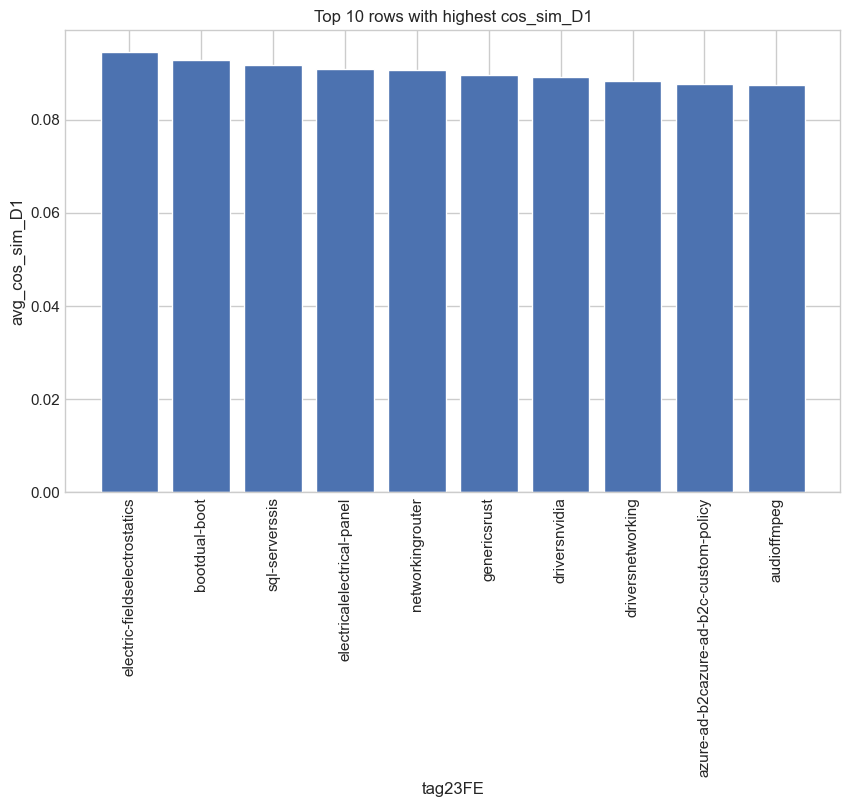

In [47]:
sorted_df_tfidf_1 = result_df_tfidf.sort_values(by='avg_cos_sim_D1', ascending=False)
top_10_rows_tfidf_1 = sorted_df_tfidf_1.head(10)
df_names_tfidf_1 = top_10_rows_tfidf_1['tag23FE']
cos_sim_diff_values_tfidf_1 = top_10_rows_tfidf_1['avg_cos_sim_D1']
plt.figure(figsize=(10, 6))
plt.bar(df_names_tfidf_1, cos_sim_diff_values_tfidf_1)
plt.xlabel('tag23FE')
plt.ylabel('avg_cos_sim_D1')
plt.title('Top 10 rows with highest cos_sim_D1')
plt.xticks(rotation=90)
plt.show()

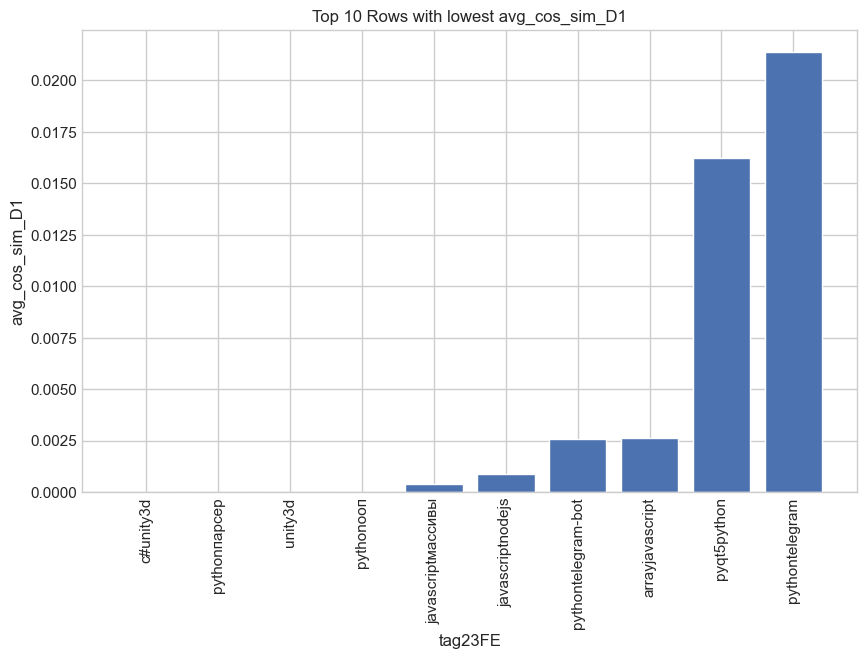

In [48]:
sorted_df_tfidf_2 = result_df_tfidf.sort_values(by='avg_cos_sim_D1', ascending=True)
top_10_rows_tfidf_2 = sorted_df_tfidf_2.head(10)
df_names_tfidf_2 = top_10_rows_tfidf_2['tag23FE']
cos_sim_diff_values_tfidf_2 = top_10_rows_tfidf_2['avg_cos_sim_D1']

plt.figure(figsize=(10, 6))
plt.bar(df_names_tfidf_2, cos_sim_diff_values_tfidf_2)
plt.xlabel('tag23FE')
plt.ylabel('avg_cos_sim_D1')
plt.title('Top 10 Rows with lowest avg_cos_sim_D1')
plt.xticks(rotation=90)
plt.show()


In [49]:
result_df_tfidf

,tag23FE,avg_cos_sim_D0,avg_cos_sim_D1
517,electric-fieldselectrostatics,0.092404,0.094465
267,bootdual-boot,0.091369,0.092797
1136,sql-serverssis,0.090041,0.091823
519,electricalelectrical-panel,0.096904,0.090932
916,networkingrouter,0.092654,0.090550
...,...,...,...
764,javascriptмассивы,0.000400,0.000400
1072,pythonпарсер,0.000858,0.000000
1071,pythonооп,0.000000,0.000000
1167,unity3d,0.000000,0.000000


In [50]:
# Create an empty DataFrame to store the results
final_result_df_tfidf = pd.DataFrame()

# Iterate over each data frame in modified_dfs
for name, df in modified_dfs.items():
    # Add a 'tag23FE' column to df to store its name
    df['tag23FE'] = name
    
    # Concatenate df with result_df_tfidf
    final_result_df_tfidf = pd.concat([final_result_df_tfidf, df], ignore_index=True)


# Save the DataFrames as CSV files
final_result_df_tfidf.to_csv('Master Thesis Data\\final_result_df_tfidf.csv', index=False)

## 6.2 LSI Score

In [51]:
# Install if needed
# !pip install gensim

In [52]:
dfs = dfs_copy.copy()

In [53]:
from gensim import corpora, models
from gensim.matutils import corpus2dense

# Create LSI vectors with 1000 features
def calculate_lsi_vectors(dfs, num_features=1000):
    lsi_vector_dict = {}

    for key, df in dfs.items():
        corpus = [text.split() for text in df["Body_clean"].fillna(" ").values]
        dictionary = corpora.Dictionary(corpus)
        corpus_bow = [dictionary.doc2bow(text) for text in corpus]

        lsi = models.LsiModel(corpus_bow, id2word=dictionary, num_topics=num_features)
        corpus_lsi = lsi[corpus_bow]
        lsi_vectors = corpus2dense(corpus_lsi, num_features).T

        lsi_vector_dict[key] = lsi_vectors

    return lsi_vector_dict

# Calculate the LSI vectors for the original dataframes
lsi_vector_dict = calculate_lsi_vectors(dfs)


In [54]:
#Function returning only the averages

def calculate_cosine_similarity_for_periods_lsi(dfs, lsi_vector_dict, n_samples=50):
    for key, df in dfs.items():
        avg_cos_sim_D0_lsi = []
        avg_cos_sim_D1_lsi = []

        df_D0T0 = df[(df['D'] == 0) & (df['T'] == 0)].reset_index(drop=True)
        df_D0T1 = df[(df['D'] == 0) & (df['T'] == 1)].sample(n_samples, random_state=42).reset_index(drop=True)
        df_D1T0 = df[(df['D'] == 1) & (df['T'] == 0)].reset_index(drop=True)
        df_D1T1 = df[(df['D'] == 1) & (df['T'] == 1)].sample(n_samples, random_state=42).reset_index(drop=True)

        # Calculate the average cosine similarity for D=0
        if not df_D0T0.empty:
            for _, row_D0T1 in df_D0T1.iterrows():
                cos_sim_values_lsi = []
                for _, row_D0T0 in df_D0T0.sample(n=min(n_samples, len(df_D0T0)), random_state=42).iterrows():
                    cos_sim_lsi = cosine_similarity(np.array(lsi_vector_dict[key][row_D0T1.name]).reshape(1, -1), np.array(lsi_vector_dict[key][row_D0T0.name]).reshape(1, -1))[0][0]
                    cos_sim_values_lsi.append(cos_sim_lsi)
                avg_cos_sim_D0_lsi.append(np.mean(cos_sim_values_lsi))
            
            # Assign avg_cos_sim_D0_lsi to df_D0T1 only if it is not empty
            if avg_cos_sim_D0_lsi:
                df_D0T1['cos_sim_D0_lsi'] = avg_cos_sim_D0_lsi

        # Calculate the average cosine similarity for D=1
        if not df_D1T0.empty:
            for _, row_D1T1 in df_D1T1.iterrows():
                cos_sim_values_lsi = []
                for _, row_D1T0 in df_D1T0.sample(n=min(n_samples, len(df_D1T0)), random_state=42).iterrows():
                    cos_sim_lsi = cosine_similarity(np.array(lsi_vector_dict[key][row_D1T1.name]).reshape(1, -1), np.array(lsi_vector_dict[key][row_D1T0.name]).reshape(1, -1))[0][0]
                    cos_sim_values_lsi.append(cos_sim_lsi)
                avg_cos_sim_D1_lsi.append(np.mean(cos_sim_values_lsi))

            # Assign avg_cos_sim_D1_lsi to df_D1T1 only if it is not empty
            if avg_cos_sim_D1_lsi:
                df_D1T1['cos_sim_D1_lsi'] = avg_cos_sim_D1_lsi

        # Concatenate the dataframes
        dfs[key] = pd.concat([df_D0T0, df_D0T1, df_D1T0, df_D1T1], ignore_index=True)

    return dfs

modified_dfs_lsi = calculate_cosine_similarity_for_periods_lsi(dfs, lsi_vector_dict)

In [55]:
# #New version - saves the individual values of cosine similarity 50 pairs for each question drawn from D0T1 and appends them as a list in the column cos_sim_D0 / D1

# def calculate_cosine_similarity_for_periods_lsi(dfs, lsi_vector_dict, n_samples=50):
#     for key, df in dfs.items():
#         all_cos_sim_D0_lsi = []
#         all_cos_sim_D1_lsi = []

#         df_D0T0 = df[(df['D'] == 0) & (df['T'] == 0)].reset_index(drop=True)
#         df_D0T1 = df[(df['D'] == 0) & (df['T'] == 1)].reset_index(drop=True)
#         df_D1T0 = df[(df['D'] == 1) & (df['T'] == 0)].reset_index(drop=True)
#         df_D1T1 = df[(df['D'] == 1) & (df['T'] == 1)].reset_index(drop=True)

#         # Calculate the cosine similarity for D=0
#         for _, row_D0T1 in df_D0T1.iterrows():
#             cos_sim_values_lsi = []
#             for _, row_D0T0 in df_D0T0.sample(n=min(n_samples, len(df_D0T0)), random_state=42).iterrows():
#                 cos_sim_lsi = cosine_similarity(lsi_vector_dict[key][row_D0T1.name].reshape(1, -1), lsi_vector_dict[key][row_D0T0.name].reshape(1, -1))[0][0]
#                 cos_sim_values_lsi.append(cos_sim_lsi)
#             all_cos_sim_D0_lsi.append(cos_sim_values_lsi)  # Append instead of extend

#         # Calculate the cosine similarity for D=1
#         for _, row_D1T1 in df_D1T1.iterrows():
#             cos_sim_values_lsi = []
#             for _, row_D1T0 in df_D1T0.sample(n=min(n_samples, len(df_D1T0)), random_state=42).iterrows():
#                 cos_sim_lsi = cosine_similarity(lsi_vector_dict[key][row_D1T1.name].reshape(1, -1), lsi_vector_dict[key][row_D1T0.name].reshape(1, -1))[0][0]
#                 cos_sim_values_lsi.append(cos_sim_lsi)
#             all_cos_sim_D1_lsi.append(cos_sim_values_lsi)  # Append instead of extend

#         df_D0T1['cos_sim_D0_lsi'] = pd.Series(all_cos_sim_D0_lsi)
#         df_D1T1['cos_sim_D1_lsi'] = pd.Series(all_cos_sim_D1_lsi)

#         # Concatenate the dataframes
#         dfs[key] = pd.concat([df_D0T0, df_D0T1, df_D1T0, df_D1T1], ignore_index=True)

#     return dfs

# # Finally, calculate the average cosine similarity for the periods D=0 and D=1
# modified_dfs_lsi = calculate_cosine_similarity_for_periods_lsi(dfs, lsi_vector_dict)


In [56]:
# # Show cos_sim_D1_lsi index 410 from android_java from modified_dfs_lsi
# modified_dfs_lsi['android_java'].loc[410, 'cos_sim_D1_lsi']

In [57]:
#Code for checking the values of the cosine similarity

# Get the first dataframe from the dictionary
first_df_key = list(modified_dfs_lsi.keys())[0]
first_df = modified_dfs_lsi[first_df_key]

# Exclude NaNs and find the first non-zero value in the 'cos_sim_D0' column
first_non_zero_index = first_df[first_df['cos_sim_D0_lsi'].notna() & (first_df['cos_sim_D0_lsi'] != 0)].first_valid_index()

# Retrieve the first non-zero, non-NaN value
first_non_zero_value = first_df.loc[first_non_zero_index, 'cos_sim_D0_lsi']
first_non_zero_value

0.11008852

In [58]:
# print the shapes of dfs in modified_dfs_lsi
for key, df in modified_dfs_lsi.items():
    print(f"DataFrame {key}: ", df.shape)

DataFrame .htaccess:  (244, 36)
DataFrame .htaccessapache:  (470, 36)
DataFrame .htaccessphp:  (330, 36)
DataFrame .net-coreasp.net-core:  (272, 36)
DataFrame .net-corec#:  (1166, 36)
DataFrame .netasp.net:  (328, 36)
DataFrame .netasp.net-core:  (270, 36)
DataFrame .netazure:  (230, 36)
DataFrame .netc#:  (6954, 36)
DataFrame .netvb.net:  (274, 36)
DataFrame .netvisual-studio:  (243, 36)
DataFrame abstract-algebra:  (291, 36)
DataFrame abstract-algebraalgebraic-geometry:  (255, 36)
DataFrame abstract-algebracommutative-algebra:  (223, 36)
DataFrame abstract-algebrafield-theory:  (289, 36)
DataFrame abstract-algebragroup-theory:  (1060, 36)
DataFrame abstract-algebralinear-algebra:  (369, 36)
DataFrame abstract-algebrapolynomials:  (240, 36)
DataFrame abstract-algebraring-theory:  (604, 36)
DataFrame ac.commutative-algebraag.algebraic-geometry:  (256, 36)
DataFrame active-directorypowershell:  (344, 36)
DataFrame activerecordruby-on-rails:  (242, 36)
DataFrame acumatica:  (221, 36)
Dat

In [59]:
# Calculate the mean of the 'avg_cos_sim_D0' column for each dataframe and round it to 4 decimal places
mean_values_lsi = {key: round(df['cos_sim_D0_lsi'].mean(), 4) for key, df in modified_dfs_lsi.items()}

# Sort the mean values in descending order
sorted_mean_values_lsi = sorted(mean_values_lsi.items(), key=lambda x: x[1], reverse=True)

# Print the sorted mean values
for key, mean in sorted_mean_values:
    print(f"Mean of 'cos_sim_D0_lsi' for DataFrame '{key}': {mean}")


Mean of 'cos_sim_D0_lsi' for DataFrame 'electricalelectrical-panel': 0.0969
Mean of 'cos_sim_D0_lsi' for DataFrame 'genericsrust': 0.096
Mean of 'cos_sim_D0_lsi' for DataFrame 'networkingrouter': 0.0927
Mean of 'cos_sim_D0_lsi' for DataFrame 'electric-fieldselectrostatics': 0.0924
Mean of 'cos_sim_D0_lsi' for DataFrame 'bootdual-boot': 0.0914
Mean of 'cos_sim_D0_lsi' for DataFrame 'driversnvidia': 0.0904
Mean of 'cos_sim_D0_lsi' for DataFrame 'sql-serverssis': 0.09
Mean of 'cos_sim_D0_lsi' for DataFrame 'audioffmpeg': 0.088
Mean of 'cos_sim_D0_lsi' for DataFrame 'azure-ad-b2cazure-ad-b2c-custom-policy': 0.0869
Mean of 'cos_sim_D0_lsi' for DataFrame 'dockergitlab': 0.0864
Mean of 'cos_sim_D0_lsi' for DataFrame 'dockernetworking': 0.0864
Mean of 'cos_sim_D0_lsi' for DataFrame 'jsonswift': 0.0862
Mean of 'cos_sim_D0_lsi' for DataFrame 'bootgrub2': 0.0859
Mean of 'cos_sim_D0_lsi' for DataFrame 'driversnetworking': 0.0844
Mean of 'cos_sim_D0_lsi' for DataFrame 'dockermysql': 0.084
Mean of '

In [60]:
#Print descriptive statistics of avg_cos_sim_D0 and avg_cos_sim_D1 all data frames in modified_dfs
for key, df in modified_dfs_lsi.items():
    print(f"DataFrame {key}:")
    print(df[['cos_sim_D0_lsi', 'cos_sim_D1_lsi']].describe())
    print()

DataFrame .htaccess:
       cos_sim_D0_lsi  cos_sim_D1_lsi
count       50.000000       50.000000
mean         0.105505        0.104362
std          0.054725        0.054992
min          0.000000        0.000000
25%          0.081679        0.076787
50%          0.111010        0.113213
75%          0.144777        0.144687
max          0.197164        0.189105

DataFrame .htaccessapache:
       cos_sim_D0_lsi  cos_sim_D1_lsi
count       50.000000       50.000000
mean         0.138239        0.130526
std          0.045999        0.040513
min          0.000000        0.000000
25%          0.106723        0.105538
50%          0.141593        0.137272
75%          0.166903        0.156908
max          0.219374        0.205118

DataFrame .htaccessphp:
       cos_sim_D0_lsi  cos_sim_D1_lsi
count       50.000000       50.000000
mean         0.109941        0.110149
std          0.062656        0.062941
min          0.000000        0.000000
25%          0.088529        0.088576
50%          0

In [61]:
# Create an empty DataFrame to store the results
result_df_lsi = pd.DataFrame(columns=['tag23FE', 'avg_cos_sim_D0_lsi', 'avg_cos_sim_D1_lsi'])

# Iterate over each data frame in modified_dfs
for name, df in modified_dfs_lsi.items():
    avg_cos_sim_D0_lsi = df['cos_sim_D0_lsi'].mean()
    avg_cos_sim_D1_lsi = df['cos_sim_D1_lsi'].mean()
    

    
    # Append the results to the result_df_lsi DataFrame
    result_df_lsi = result_df_lsi.append({'tag23FE': name, 
                                          'avg_cos_sim_D0_lsi': avg_cos_sim_D0_lsi,
                                          'avg_cos_sim_D1_lsi': avg_cos_sim_D1_lsi}, 
                                         ignore_index=True)

# Display the result_df_lsi DataFrame
print(result_df_lsi)


C:\Users\piotr\AppData\Local\Temp\ipykernel_4792\229505.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df_lsi = result_df_lsi.append({'tag23FE': name,
C:\Users\piotr\AppData\Local\Temp\ipykernel_4792\229505.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df_lsi = result_df_lsi.append({'tag23FE': name,
C:\Users\piotr\AppData\Local\Temp\ipykernel_4792\229505.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df_lsi = result_df_lsi.append({'tag23FE': name,
C:\Users\piotr\AppData\Local\Temp\ipykernel_4792\229505.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df_lsi = result_df_lsi.append({'tag2

                    tag23FE  avg_cos_sim_D0_lsi  avg_cos_sim_D1_lsi
0                 .htaccess            0.105505            0.104362
1           .htaccessapache            0.138239            0.130526
2              .htaccessphp            0.109941            0.110149
3     .net-coreasp.net-core            0.087182            0.086930
4               .net-corec#            0.062168            0.067049
...                     ...                 ...                 ...
1183  word-choiceword-usage            0.048944            0.051523
1184              wordpress            0.049082            0.046976
1185                wpfxaml            0.091455            0.088767
1186   xamarinxamarin.forms            0.057424            0.064802
1187                xmlxslt            0.146253            0.148550

[1188 rows x 3 columns]


C:\Users\piotr\AppData\Local\Temp\ipykernel_4792\229505.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df_lsi = result_df_lsi.append({'tag23FE': name,
C:\Users\piotr\AppData\Local\Temp\ipykernel_4792\229505.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df_lsi = result_df_lsi.append({'tag23FE': name,
C:\Users\piotr\AppData\Local\Temp\ipykernel_4792\229505.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df_lsi = result_df_lsi.append({'tag23FE': name,
C:\Users\piotr\AppData\Local\Temp\ipykernel_4792\229505.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df_lsi = result_df_lsi.append({'tag2

In [62]:
#Sort is descending order
result_df_lsi.sort_values(by='avg_cos_sim_D1_lsi', ascending=False, inplace=True)
result_df_lsi

,tag23FE,avg_cos_sim_D0_lsi,avg_cos_sim_D1_lsi
267,bootdual-boot,0.223773,0.223329
517,electric-fieldselectrostatics,0.215056,0.218024
1161,typescripttypescript-generics,0.192183,0.205534
488,dockerjenkins,0.207216,0.204461
88,androidandroid-fragments,0.201073,0.201544
...,...,...,...
764,javascriptмассивы,0.000400,0.000400
1072,pythonпарсер,0.000902,0.000000
1071,pythonооп,0.000000,0.000000
304,c#unity3d,0.000400,0.000000


In [63]:

# Create final_result_df_lsi
final_result_df_lsi = pd.DataFrame()

# Iterate over each data frame in modified_dfs_lsi
for name, df in modified_dfs_lsi.items():
    # Add a 'tag23FE' column to df to store its name
    df['tag23FE'] = name
    
    # Concatenate df with final_result_df_lsi
    final_result_df_lsi = pd.concat([final_result_df_lsi, df], ignore_index=True)

final_result_df_lsi.to_csv('Master Thesis Data\\final_result_df_lsi.csv', index=False)


## 6.3 Doc2Vect

In [20]:
dfs = dfs_copy.copy()

The code below is meant to use with the english wikipedia as a larger external corpora. I assume it's better to do it using the virtual machine.

In [ ]:
# !pip install wikiextractor

In [ ]:
# wikiextractor --processes 4 --output extracted_wikipedia enwiki-latest-pages-articles.xml.bz2

In [ ]:
# def iter_wikipedia_files(path):
#     for dirname, _, files in os.walk(path):
#         for filename in files:
#             filepath = os.path.join(dirname, filename)
#             with open(filepath, 'r', encoding='utf-8') as f:
#                 content = f.read()
#             yield content

# def train_doc2vec_model_on_wikipedia(path, vector_size=100, window=5, min_count=2, workers=4, epochs=20):
#     documents = [TaggedDocument(simple_preprocess(doc), [i]) for i, doc in enumerate(iter_wikipedia_files(path))]

#     doc2vec_model = Doc2Vec(documents, vector_size=vector_size, window=window, min_count=min_count, workers=workers, epochs=epochs)
#     return doc2vec_model

# wikipedia_path = "extracted_wikipedia" # Replace with the path where you saved the extracted Wikipedia text files
# doc2vec_model_wikipedia = train_doc2vec_model_on_wikipedia(wikipedia_path)


Current code - corpora based on the text from the data base

In [24]:
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument


def train_doc2vec_model(dfs):
    all_posts = []
    for key, df in dfs.items():
        all_posts.extend(df["Body_clean"].fillna(" ").values)

    documents = [TaggedDocument(simple_preprocess(doc), [i]) for i, doc in enumerate(all_posts)]

    # Lower vector size to decrease the complexity of the model
    # Increase min_count to ignore rare words which might not contribute much to the model
    # Decrease the number of epochs to lessen the training time
    doc2vec_model = Doc2Vec(documents, vector_size=10, window=5, min_count=5, workers=8, epochs=10)

    return doc2vec_model

doc2vec_model = train_doc2vec_model(dfs)


In [25]:
def calculate_doc_vectors(dfs, doc2vec_model):
    doc_vectors = {}
    for key, df in dfs.items():
        doc_vectors[key] = [doc2vec_model.infer_vector(simple_preprocess(text)) for text in df["Body_clean"].fillna(" ").values]
    return doc_vectors

doc_vectors_dict = calculate_doc_vectors(dfs, doc2vec_model)

In [ ]:
# #New function
# def calculate_cosine_similarity_for_periods_doc2vec(dfs, doc_vectors_dict, n_samples=50):
#     # Create an empty DataFrame to store the results
#     results_df = pd.DataFrame()

#     for key, df in dfs.items():
#         all_cos_sim_D0 = []
#         all_cos_sim_D1 = []

#         df_D0T0 = df[(df['D'] == 0) & (df['T'] == 0)].reset_index(drop=True)
#         df_D0T1 = df[(df['D'] == 0) & (df['T'] == 1)].reset_index(drop=True)
#         df_D1T0 = df[(df['D'] == 1) & (df['T'] == 0)].reset_index(drop=True)
#         df_D1T1 = df[(df['D'] == 1) & (df['T'] == 1)].reset_index(drop=True)

#         # Calculate the cosine similarity for D=0
#         for _, row_D0T1 in df_D0T1.iterrows():
#             for _, row_D0T0 in df_D0T0.sample(n=min(n_samples, len(df_D0T0)), random_state=42).iterrows():
#                 cos_sim = cosine_similarity(doc_vectors_dict[key][row_D0T1.name].reshape(1, -1), doc_vectors_dict[key][row_D0T0.name].reshape(1, -1))[0][0]

#                 # Create a new entry with the relevant data and append it to results_df
#                 new_entry = {
#                     'tag23FE': key,
#                     'D0T1_question_date': row_D0T1['date_day'],
#                     'D0T1_question_index': row_D0T1.name,
#                     'D0T0_question_date': row_D0T0['date_day'],
#                     'D0T0_question_index': row_D0T0.name,
#                     'cos_sim': cos_sim
#                 }
#                 results_df = results_df.append(new_entry, ignore_index=True)

#         # Calculate the cosine similarity for D=1
#         for _, row_D1T1 in df_D1T1.iterrows():
#             for _, row_D1T0 in df_D1T0.sample(n=min(n_samples, len(df_D1T0)), random_state=42).iterrows():
#                 cos_sim = cosine_similarity(doc_vectors_dict[key][row_D1T1.name].reshape(1, -1), doc_vectors_dict[key][row_D1T0.name].reshape(1, -1))[0][0]

#                 # Create a new entry with the relevant data and append it to results_df
#                 new_entry = {
#                     'tag23FE': key,
#                     'D1T1_question_date': row_D1T1['date_day'],
#                     'D1T1_question_index': row_D1T1.name,
#                     'D1T0_question_date': row_D1T0['date_day'],
#                     'D1T0_question_index': row_D1T0.name,
#                     'cos_sim': cos_sim
#                 }
#                 results_df = results_df.append(new_entry, ignore_index=True)

#     return results_df

# # Call the function and save the result to a variable
# results_df_doc2vec = calculate_cosine_similarity_for_periods_doc2vec(dfs, doc_vectors_dict)


#### Comment out this

In [26]:
#Function returning only the averages
def calculate_cosine_similarity_for_periods_doc2vec(dfs, doc_vectors_dict, n_samples=50):
    for key, df in dfs.items():
        avg_cos_sim_D0 = []
        avg_cos_sim_D1 = []

        df_D0T0 = df[(df['D'] == 0) & (df['T'] == 0)].reset_index(drop=True)
        df_D0T1 = df[(df['D'] == 0) & (df['T'] == 1)].sample(n_samples, random_state=42).reset_index(drop=True)
        df_D1T0 = df[(df['D'] == 1) & (df['T'] == 0)].reset_index(drop=True)
        df_D1T1 = df[(df['D'] == 1) & (df['T'] == 1)].sample(n_samples, random_state=42).reset_index(drop=True)

        # Calculate the average cosine similarity for D=0
        if not df_D0T0.empty:
            for _, row_D0T1 in df_D0T1.iterrows():
                cos_sim_values = []
                for _, row_D0T0 in df_D0T0.sample(n=min(n_samples, len(df_D0T0)), random_state=42).iterrows():
                    cos_sim = cosine_similarity(doc_vectors_dict[key][row_D0T1.name].reshape(1, -1), doc_vectors_dict[key][row_D0T0.name].reshape(1, -1))[0][0]
                    cos_sim_values.append(cos_sim)
                avg_cos_sim_D0.append(np.mean(cos_sim_values))
            
            # Assign avg_cos_sim_D0 to df_D0T1 only if it is not empty
            if avg_cos_sim_D0:
                df_D0T1['cos_sim_D0_doc2vec'] = avg_cos_sim_D0

        # Calculate the average cosine similarity for D=1
        if not df_D1T0.empty:
            for _, row_D1T1 in df_D1T1.iterrows():
                cos_sim_values = []
                for _, row_D1T0 in df_D1T0.sample(n=min(n_samples, len(df_D1T0)), random_state=42).iterrows():
                    cos_sim = cosine_similarity(doc_vectors_dict[key][row_D1T1.name].reshape(1, -1), doc_vectors_dict[key][row_D1T0.name].reshape(1, -1))[0][0]
                    cos_sim_values.append(cos_sim)
                avg_cos_sim_D1.append(np.mean(cos_sim_values))
            
            # Assign avg_cos_sim_D1 to df_D1T1 only if it is not empty
            if avg_cos_sim_D1:
                df_D1T1['cos_sim_D1_doc2vec'] = avg_cos_sim_D1

        # Concatenate the dataframes
        dfs[key] = pd.concat([df_D0T0, df_D0T1, df_D1T0, df_D1T1], ignore_index=True)

    return dfs

modified_dfs_doc2vec = calculate_cosine_similarity_for_periods_doc2vec(dfs, doc_vectors_dict)

In [ ]:
# #Function returning the cosine similarity values for each pair of questions

# def calculate_cosine_similarity_for_periods_doc2vec(dfs, doc_vectors_dict, n_samples=50):
#     for key, df in dfs.items():
#         all_cos_sim_D0 = []
#         all_cos_sim_D1 = []

#         df_D0T0 = df[(df['D'] == 0) & (df['T'] == 0)].reset_index(drop=True)
#         df_D0T1 = df[(df['D'] == 0) & (df['T'] == 1)].reset_index(drop=True)
#         df_D1T0 = df[(df['D'] == 1) & (df['T'] == 0)].reset_index(drop=True)
#         df_D1T1 = df[(df['D'] == 1) & (df['T'] == 1)].reset_index(drop=True)

#         # Calculate the cosine similarity for D=0
#         for _, row_D0T1 in df_D0T1.iterrows():
#             cos_sim_values = []
#             for _, row_D0T0 in df_D0T0.sample(n=min(n_samples, len(df_D0T0)), random_state=42).iterrows():
#                 cos_sim = cosine_similarity(doc_vectors_dict[key][row_D0T1.name].reshape(1, -1), doc_vectors_dict[key][row_D0T0.name].reshape(1, -1))[0][0]
#                 cos_sim_values.append(cos_sim)
#             all_cos_sim_D0.append(cos_sim_values)  # Append instead of extend

#         # Calculate the cosine similarity for D=1
#         for _, row_D1T1 in df_D1T1.iterrows():
#             cos_sim_values = []
#             for _, row_D1T0 in df_D1T0.sample(n=min(n_samples, len(df_D1T0)), random_state=42).iterrows():
#                 cos_sim = cosine_similarity(doc_vectors_dict[key][row_D1T1.name].reshape(1, -1), doc_vectors_dict[key][row_D1T0.name].reshape(1, -1))[0][0]
#                 cos_sim_values.append(cos_sim)
#             all_cos_sim_D1.append(cos_sim_values)  # Append instead of extend

#         df_D0T1['cos_sim_D0_doc2vec'] = pd.Series(all_cos_sim_D0)
#         df_D1T1['cos_sim_D1_doc2vec'] = pd.Series(all_cos_sim_D1)

#         # Concatenate the dataframes
#         dfs[key] = pd.concat([df_D0T0, df_D0T1, df_D1T0, df_D1T1], ignore_index=True)

#     return dfs

# modified_dfs_doc2vec = calculate_cosine_similarity_for_periods_doc2vec(dfs, doc_vectors_dict)


#### Relevant part

In [ ]:
# results_df_doc2vec['android_java'].loc[410, 'cos_sim_D1_doc2vec']

In [ ]:
# print the shapes of dfs in modified_dfs_doc2vec
for key, df in modified_dfs_doc2vec.items():
    print(f"DataFrame {key}: ", df.shape)

DataFrame .netc#:  (316, 27)
DataFrame androidjava:  (405, 27)
DataFrame androidkotlin:  (336, 27)
DataFrame c#unity-game-engine:  (202, 27)
DataFrame csshtml:  (623, 27)
DataFrame dartflutter:  (516, 27)
DataFrame djangopython:  (396, 27)
DataFrame excelvba:  (333, 27)
DataFrame flutter:  (203, 27)
DataFrame ggplot2r:  (251, 27)
DataFrame htmljavascript:  (915, 27)
DataFrame iosswift:  (350, 27)
DataFrame javascript:  (425, 27)
DataFrame javascriptjquery:  (313, 27)
DataFrame javascriptnode.js:  (587, 27)
DataFrame javascriptreactjs:  (923, 27)
DataFrame javaspring:  (326, 27)
DataFrame javaspring-boot:  (263, 27)
DataFrame laravelphp:  (333, 27)
DataFrame numpypython:  (235, 27)
DataFrame oraclesql:  (215, 27)
DataFrame pandaspython:  (1145, 27)
DataFrame python:  (569, 27)
DataFrame pythonpython-3.x:  (743, 27)
DataFrame r:  (279, 27)
DataFrame sqlsql-server:  (262, 27)


In [ ]:
# print the shapes of dfs in modified_dfs_doc2vec
for key, df in modified_dfs_doc2vec.items():
    print(f"DataFrame {key}: ", df.shape)

DataFrame .netc#:  (316, 27)
DataFrame androidjava:  (405, 27)
DataFrame androidkotlin:  (336, 27)
DataFrame c#unity-game-engine:  (202, 27)
DataFrame csshtml:  (623, 27)
DataFrame dartflutter:  (516, 27)
DataFrame djangopython:  (396, 27)
DataFrame excelvba:  (333, 27)
DataFrame flutter:  (203, 27)
DataFrame ggplot2r:  (251, 27)
DataFrame htmljavascript:  (915, 27)
DataFrame iosswift:  (350, 27)
DataFrame javascript:  (425, 27)
DataFrame javascriptjquery:  (313, 27)
DataFrame javascriptnode.js:  (587, 27)
DataFrame javascriptreactjs:  (923, 27)
DataFrame javaspring:  (326, 27)
DataFrame javaspring-boot:  (263, 27)
DataFrame laravelphp:  (333, 27)
DataFrame numpypython:  (235, 27)
DataFrame oraclesql:  (215, 27)
DataFrame pandaspython:  (1145, 27)
DataFrame python:  (569, 27)
DataFrame pythonpython-3.x:  (743, 27)
DataFrame r:  (279, 27)
DataFrame sqlsql-server:  (262, 27)


In [ ]:
#Print descriptive statistics of avg_cos_sim_D0 and avg_cos_sim_D1 all data frames in modified_dfs
for key, df in modified_dfs_doc2vec.items():
    print(f"DataFrame {key}:")
    print(df[['cos_sim_D1_doc2vec', 'cos_sim_D1_doc2vec']].describe())
    print()

DataFrame .netc#:
       cos_sim_D1_doc2vec  cos_sim_D1_doc2vec
count           50.000000           50.000000
mean             0.152190            0.152190
std              0.069493            0.069493
min             -0.101358           -0.101358
25%              0.137415            0.137415
50%              0.162865            0.162865
75%              0.184857            0.184857
max              0.303567            0.303567

DataFrame androidjava:
       cos_sim_D1_doc2vec  cos_sim_D1_doc2vec
count           50.000000           50.000000
mean             0.192598            0.192598
std              0.075882            0.075882
min             -0.024386           -0.024386
25%              0.154699            0.154699
50%              0.195469            0.195469
75%              0.234271            0.234271
max              0.358997            0.358997

DataFrame androidkotlin:
       cos_sim_D1_doc2vec  cos_sim_D1_doc2vec
count           50.000000           50.000000
mean        

In [27]:
# Create an empty DataFrame to store the results
result_df_doc2vec = pd.DataFrame(columns=['tag23FE', 'avg_cos_sim_D0_doc2vec', 'avg_cos_sim_D1_doc2vec'])

# Iterate over each data frame in modified_dfs
for name, df in modified_dfs_doc2vec.items():
    avg_cos_sim_D0_doc2vec = df['cos_sim_D0_doc2vec'].mean()
    avg_cos_sim_D1_doc2vec = df['cos_sim_D1_doc2vec'].mean()
    
    # Append the results to the result_df_doc2vec DataFrame
    result_df_doc2vec = result_df_doc2vec.append ({'tag23FE': name, 
                                          'avg_cos_sim_D0_doc2vec': avg_cos_sim_D0_doc2vec,
                                          'avg_cos_sim_D1_doc2vec': avg_cos_sim_D1_doc2vec},
                                         ignore_index=True)

# Display the result_df_doc2vec DataFrame
print(result_df_doc2vec)



C:\Users\piotr\AppData\Local\Temp\ipykernel_19488\2753259705.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df_doc2vec = result_df_doc2vec.append ({'tag23FE': name,
C:\Users\piotr\AppData\Local\Temp\ipykernel_19488\2753259705.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df_doc2vec = result_df_doc2vec.append ({'tag23FE': name,
C:\Users\piotr\AppData\Local\Temp\ipykernel_19488\2753259705.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df_doc2vec = result_df_doc2vec.append ({'tag23FE': name,
C:\Users\piotr\AppData\Local\Temp\ipykernel_19488\2753259705.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead

                    tag23FE  avg_cos_sim_D0_doc2vec  avg_cos_sim_D1_doc2vec
0                 .htaccess                0.483596                0.467292
1           .htaccessapache                0.619001                0.617088
2              .htaccessphp                0.421793                0.414766
3     .net-coreasp.net-core                0.501855                0.493098
4               .net-corec#                0.513357                0.510243
...                     ...                     ...                     ...
1183  word-choiceword-usage                0.570647                0.560340
1184              wordpress                0.463623                0.389256
1185                wpfxaml                0.516347                0.510116
1186   xamarinxamarin.forms                0.450470                0.487637
1187                xmlxslt                0.632635                0.625448

[1188 rows x 3 columns]


C:\Users\piotr\AppData\Local\Temp\ipykernel_19488\2753259705.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df_doc2vec = result_df_doc2vec.append ({'tag23FE': name,
C:\Users\piotr\AppData\Local\Temp\ipykernel_19488\2753259705.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df_doc2vec = result_df_doc2vec.append ({'tag23FE': name,
C:\Users\piotr\AppData\Local\Temp\ipykernel_19488\2753259705.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df_doc2vec = result_df_doc2vec.append ({'tag23FE': name,
C:\Users\piotr\AppData\Local\Temp\ipykernel_19488\2753259705.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead

In [ ]:
#Sort is descending order
result_df_doc2vec.sort_values(by='avg_cos_sim_D1_doc2vec', ascending=False, inplace=True)
result_df_doc2vec

,tag23FE,avg_cos_sim_D0_doc2vec,avg_cos_sim_D1_doc2vec
9,ggplot2r,0.294639,0.294456
3,c#unity-game-engine,0.245864,0.243302
20,oraclesql,0.212240,0.222237
7,excelvba,0.216619,0.219800
19,numpypython,0.226687,0.218701
24,r,0.230429,0.218099
25,sqlsql-server,0.215291,0.209212
21,pandaspython,0.181505,0.207702
16,javaspring,0.221267,0.203908
17,javaspring-boot,0.197565,0.200606


Save the results

Rename the columns back

In [ ]:
# df = df.rename(columns={'Body': 'Post_Body', 'Body_clean': 'Post_Body_clean', 'tag23FE' : 'tag_combined'})

In [ ]:
#Create the result data frames and save them as csv files

In [28]:

# Create final_result_df_doc2vec
final_result_df_doc2vec = pd.DataFrame()

# Iterate over each data frame in modified_dfs_doc2vec
for name, df in modified_dfs_doc2vec.items():
    # Add a 'tag23FE' column to df to store its name
    df['tag23FE'] = name
    
    # Concatenate df with final_result_df_doc2vec
    final_result_df_doc2vec = pd.concat([final_result_df_doc2vec, df], ignore_index=True)

# Save the DataFrames as CSV files
final_result_df_doc2vec.to_csv('Master Thesis Data\\final_result_df_doc2vec.csv', index=False)


In [29]:
end_time = time.time()
total_time = end_time - start_time
print("Total execution time: {:.2f} seconds".format(total_time))

Total execution time: 4261.11 seconds
